# SeismoStats: How To
<div class="alert alert-block alert-info">

#### In this notebook we will show how to:

<ol>
    <li> Make a catalog object
    <ol>
        <li> by downloading it
        <li> by converting a csv file
    </ol>
    <li>Plot the seismicity</li>
    <li>Analyze the FMD</li>
    <ol>
         <li>Plot the FMD</li> 
        <li>Estimate the magnitude of completeness</li> 
        <li>Estimate b-values</li> 
    </ol>
    <li>Generate synthetic magnitudes</li>
    <li>Bin magnitudes</li>
</ol>

</div>

## 0. Import general packages

In [2]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Make a catalog object

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The catalog object is a dataframe, with some additional methods and attributes.
The columns are:

|column header |type | importance|
|:-|:-|:-|
|latitude |float |required|
|longitude |float |required|
|depth| float| required|
|mag_type| string| optional|
|magnitude| float| required| 
|time| pandas timestamp| required|
|event_type| string| optional|
</font>
</div>

### 1.1 Download catalog

In [3]:
from seismostats.io.client import FDSNWSEventClient

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [4]:
start_time = pd.to_datetime('2018/01/01')
end_time = pd.to_datetime('2022/01/01')

min_longitude = 5
max_longitude = 11
min_latitude = 45
max_latitude = 48

min_magnitude = 0.5
url = 'http://arclink.ethz.ch/fdsnws/event/1/query'
client = FDSNWSEventClient(url)
df = client.get_events(
    start_time=start_time,
    end_time=end_time,
    min_magnitude=min_magnitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_latitude=min_latitude,
    max_latitude=max_latitude)

<font color=#208de2> The output is a catalog object</font>

In [4]:
df.tail()

,event_type,time,latitude,longitude,depth,evaluationmode,magnitude,magnitude_type,magnitude_MLhc,magnitude_MLh,magnitude_MLv
5443,earthquake,2018-01-03 04:58:53.924261,47.331523,6.514297,1246.093750,manual,2.255344,MLh,NaN,2.255344194,NaN
5444,earthquake,2018-01-03 01:23:25.743609,47.334795,6.526562,1042.968750,manual,2.226472,MLh,NaN,2.226472471,NaN
5445,earthquake,2018-01-02 14:59:24.558209,46.671013,8.498117,7263.671875,manual,2.002621,MLh,NaN,2.002620914,NaN
5446,earthquake,2018-01-02 11:16:14.375745,46.107432,6.874558,8228.515625,manual,2.670364,MLh,NaN,2.670364054,NaN
5447,earthquake,2018-01-02 06:26:54.928459,46.665287,9.992356,4927.734375,manual,1.300392,MLh,NaN,1.300391562,NaN


### 1.2 Convert a dataframe into a catalog

## 2. Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We have three basic plots of the seismicity

<ol>
<li>Seismicity in space</li>
<li>Cumulative count</li> 
<li>Magnitudes in time</li> 
</ol>

</font>
</div>

### 2.1. Plot in space

In [5]:
from seismostats import plot_in_space

<font color=#208de2>
It is possible to choose the resolutions 10, 50 and 110. Optionally you can choose the color scheme and the country of which you want to see the borders. For large areas/countries, the plotting can take some time.
</font>


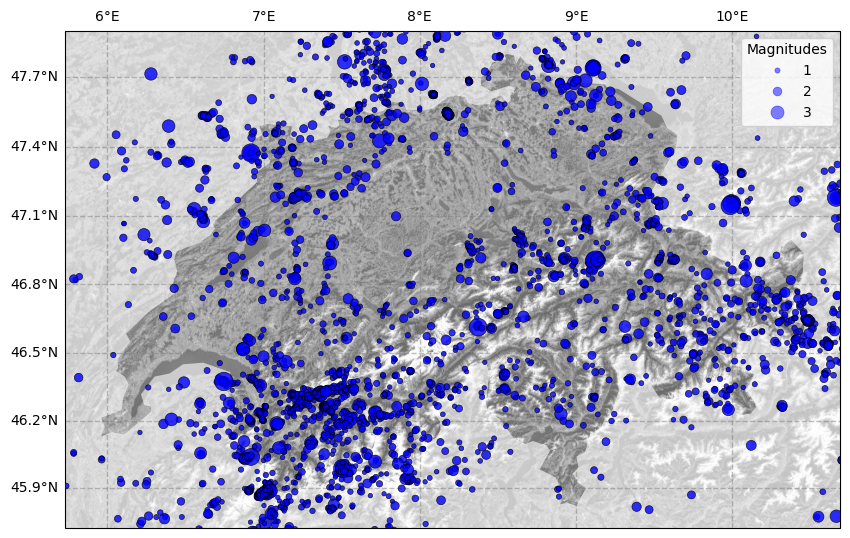

In [6]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, resolution='10m', include_map=True, country='Switzerland', colors='Greys_r', dot_labels=[1,2,3])

<font color=#208de2>
You can also choose the interpolation power and the size of the smallest and largest dot. 
</font>


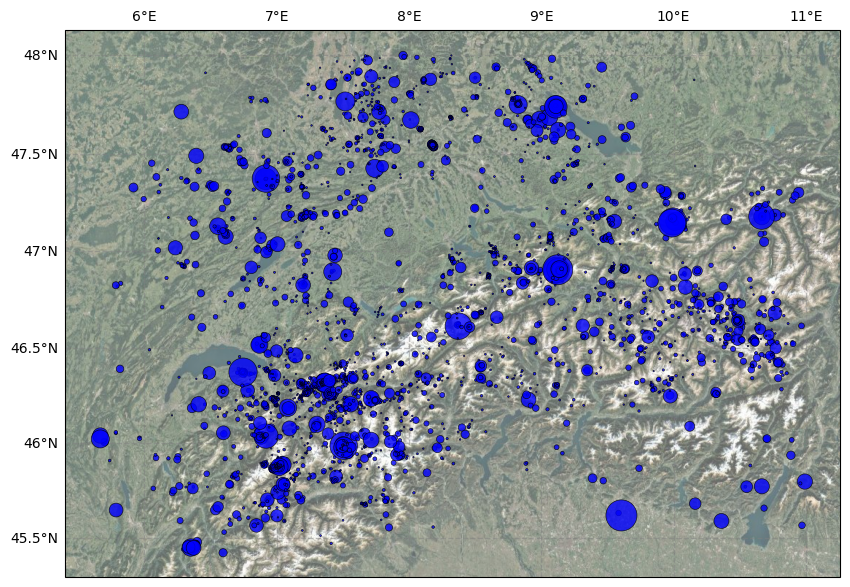

In [7]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, resolution='10m', include_map=True, dot_smallest=1, dot_largest=500, dot_interpolation_power=3, dot_labels=None)

<font color=#208de2>
The default is that the map is not included.
</font>

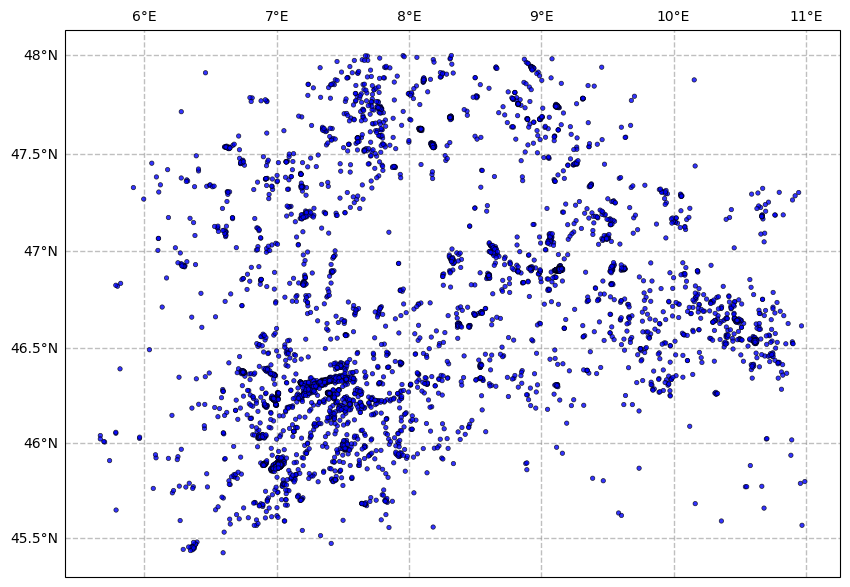

In [8]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, dot_smallest=0.1, dot_largest=10, dot_interpolation_power=0, dot_labels=False)

### 2.2. Plot in time

In [4]:
from seismostats import plot_cum_count, plot_mags_in_time

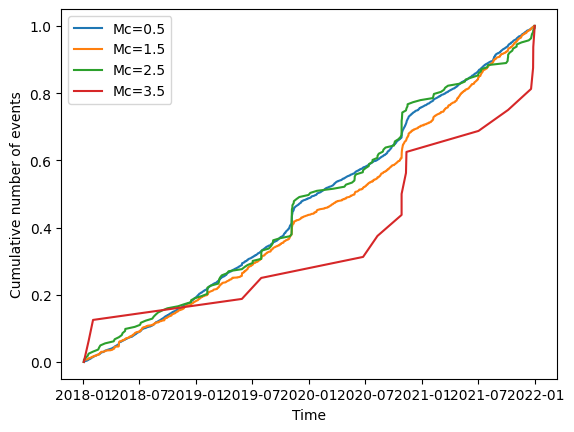

In [5]:
ax = plot_cum_count(df, mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

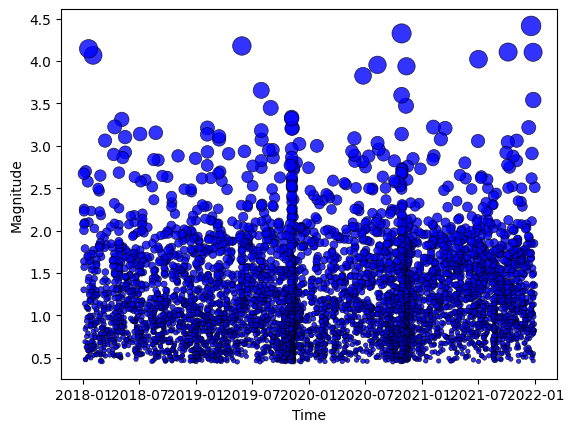

In [11]:
ax = plot_mags_in_time(df)

## 3. analysze the FMD

### 3.1 Plot magnitude distributions

In [6]:
from seismostats import plot_cum_fmd, plot_fmd

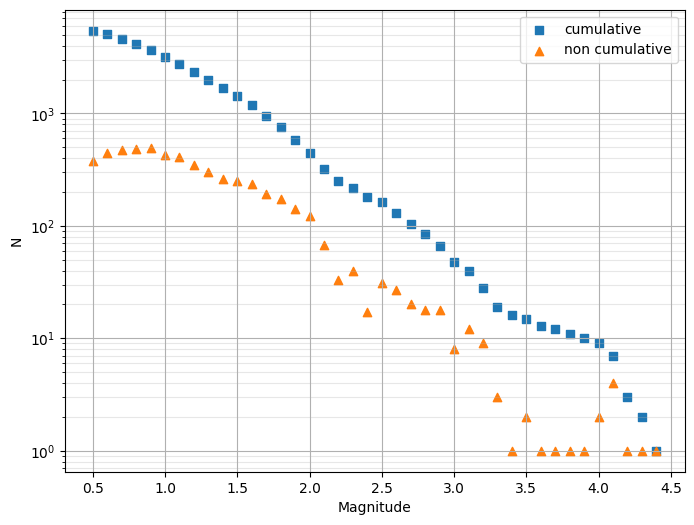

In [13]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax)
plot_fmd(df['magnitude'], ax=ax, grid=True)

plt.show()

### 3.2 Estimate completeness magnitude

In [4]:
from seismostats.analysis.estimate_mc import mc_ks, mc_max_curvature, mc_by_bvalue_stability
from seismostats.utils.binning import bin_to_precision

In [5]:
mc_stab, best_b, mcs_test, bs, diff_bs = mc_by_bvalue_stability(df['magnitude'], delta_m=0.01, stop_when_passed=True)
print(f'Stability method: Mc = {mc_stab:.2f}')

Stability method: Mc = 1.49


In [6]:
mc = mc_max_curvature(df['magnitude'], delta_m=0.1)
print(f'Maximum curvature method: Mc = {mc:.1f}')

Maximum curvature method: Mc = 1.1


In [17]:
mc_kstest, beta_kstest, mcs_tested, betas, ks_ds, ps = mc_ks(
    bin_to_precision(df['magnitude'], 0.1),
    delta_m=0.1,
    p_pass=0.1,
) 

print(f"KS test method:")
print("Tested Mc values:", mcs_tested)
print("First Mc to pass the KS test:", mc_kstest)
print(f"Associated beta value: {beta_kstest:.2f}")

KS test method:
Tested Mc values: [np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.1), np.float64(1.2), np.float64(1.3), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.7), np.float64(1.8), np.float64(1.9), np.float64(2.0), np.float64(2.1), np.float64(2.2), np.float64(2.3), np.float64(2.4), np.float64(2.5)]
First Mc to pass the KS test: 2.5
Associated beta value: 2.32


This method takes longer, especially when the magnitude sample is large.

If Mc is known to be larger than a certain value, giving the Mc values that should be tested as an input can make the Mc estimation faster.

In [18]:
# if Mc is known to be larger than or equal to 1.0

mc_kstest, beta_kstest, mcs_tested, betas, ks_ds, ps = mc_ks(
    bin_to_precision(df['magnitude'], 0.1),
    mcs_test=bin_to_precision(np.arange(1.0, 3.0, 0.1), 0.1),
    delta_m=0.1,
    p_pass=0.1,
) 

print("Tested Mc values:", mcs_tested)
print("First Mc to pass the KS test:", mc_kstest)
print(f"Associated beta value: {beta_kstest:.2f}")

Tested Mc values: [np.float64(1.0), np.float64(1.1), np.float64(1.2), np.float64(1.3), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.7), np.float64(1.8), np.float64(1.9), np.float64(2.0), np.float64(2.1), np.float64(2.2), np.float64(2.3), np.float64(2.4), np.float64(2.5)]
First Mc to pass the KS test: 2.5
Associated beta value: 2.32


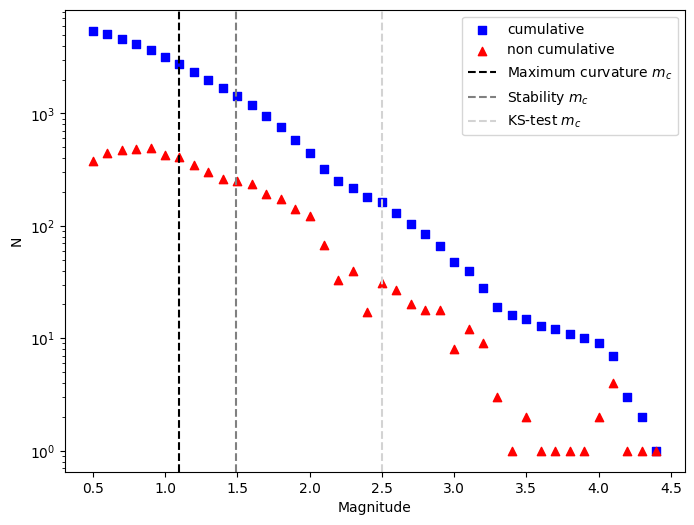

In [19]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, color='blue')
plot_fmd(df['magnitude'], ax=ax, color='red')

plt.axvline(mc, color='black', linestyle='--', label='Maximum curvature $m_c$')
plt.axvline(mc_stab, color='grey', linestyle='--', label='Stability $m_c$')
plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')

plt.legend()
plt.show()

### 3.3 Estimate the b-value

In [10]:
from seismostats import estimate_b, bin_to_precision
from seismostats.plots.statistical import plot_mc_vs_b

In [11]:
delta_m = 0.1
mags = df['magnitude']
mags = bin_to_precision(mags, delta_m)

In [22]:
b_estimate, error = estimate_b(mags[mags>=mc], mc=mc, delta_m=delta_m, return_std=True, b_parameter='b_value')

b_estimate2, error = estimate_b(mags[mags>=mc_kstest], mc=mc_kstest, delta_m=delta_m, return_std=True, b_parameter='b_value')

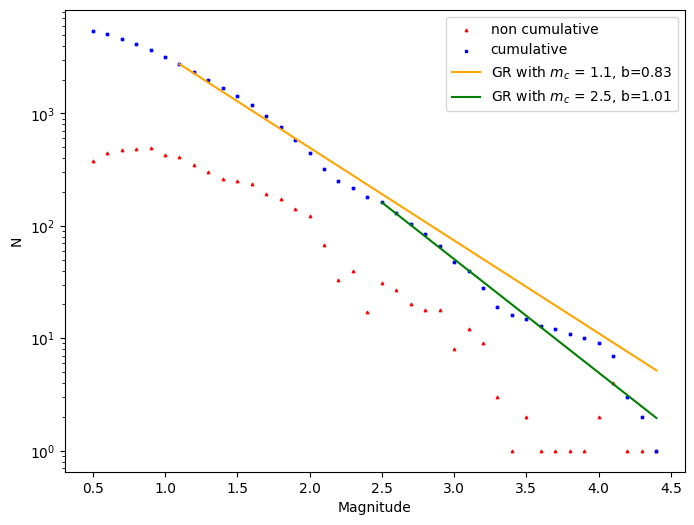

In [23]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_fmd(df['magnitude'], ax=ax, color='red', size=3)

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, color=['blue', 'orange'], b_value=b_estimate, mc=mc, 
             size=3, legend=['cumulative', r'GR with $m_c$ = {:.1f}'.format(mc)])
plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, b_value=b_estimate2, mc=mc_kstest, color = ['blue', 'green'], 
             size=3, legend=['_', r'GR with $m_c$ = {:.1f}'.format(mc_kstest)])

plt.show()


<font color=#208de2> We can also plot the b-value for different mc: </font>

<Axes: xlabel='Completeness magnitude $m_c$', ylabel='b-value'>

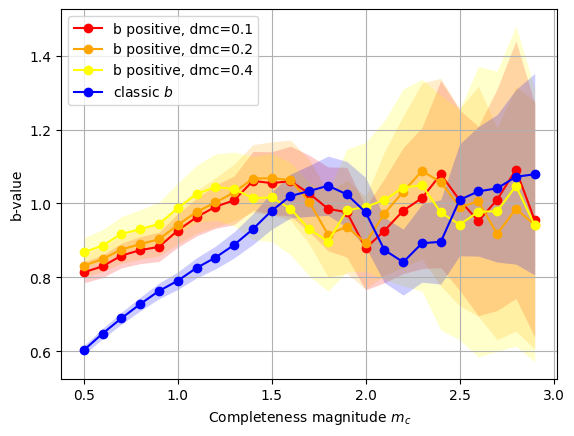

In [12]:
from seismostats.analysis.bvalue import ClassicBValueEstimator, BPositiveBValueEstimator

mcs = np.arange(0.5, 3, 0.1)
ax = plot_mc_vs_b(mags, mcs, delta_m, b_method=BPositiveBValueEstimator, dmc=0.1, color='red', label='b positive, dmc=0.1')
plot_mc_vs_b(mags, mcs, delta_m, b_method=BPositiveBValueEstimator, dmc=0.2, ax=ax,  color='orange', label='b positive, dmc=0.2')
plot_mc_vs_b(mags, mcs, delta_m, b_method=BPositiveBValueEstimator, dmc=0.4, ax=ax,  color='yellow', label='b positive, dmc=0.4')

plot_mc_vs_b(mags, mcs, delta_m, b_method=ClassicBValueEstimator, ax =ax, color='blue', label='classic $b$')

### 3.4 Check if the b-value changes significantly

<font color=#208de2> Once we picked a fitting completeness, we might also want to see how the b-value changes with time (or along any other dimension) </font>

In [5]:
from seismostats.analysis.b_significant import mac_1D_constant_nm
from seismostats import bin_to_precision
from seismostats.plots.statistical import plot_b_series_constant_nm, plot_nm_vs_mac1D
from scipy.stats import norm

from seismostats.analysis.bvalue import BPositiveBValueEstimator

In [6]:
mc = 1.0
delta_m = 0.1

times = df['time'].values
mags = df['magnitude'].values
mags = bin_to_precision(mags, delta_m)

Text(0.5, 0, 'Time')

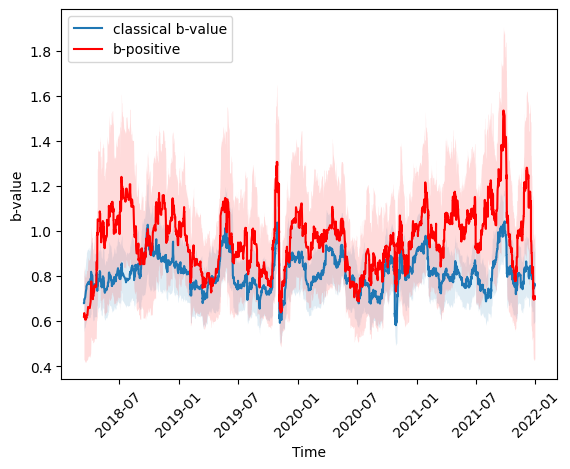

In [7]:
n_m = 100 # number of magnitudes taken per estimate in the running window

idx = mags >= mc
ax = plot_b_series_constant_nm(mags[idx], delta_m, mc, times[idx], n_m=n_m,x_variable=times[idx], color='#1f77b4', plot_technique='right', label='classical b-value')

ax = plot_b_series_constant_nm(mags[idx], delta_m, mc, times[idx], n_m=n_m,x_variable=times[idx], color='red', plot_technique='right', label='b-positive', ax=ax, b_method=BPositiveBValueEstimator)

_ = plt.xticks(rotation=45)
ax.set_xlabel('Time')

<font color=#208de2> Looking at the time-series above, one could be interested if the variation of the b-value is larger than what one would expect just from random fluctuation of the estimate. In other words, we want to know if we can reject the null-hypothesis that the true b-value is constant. For this, we can apply the method of Mirwald et. al., 2024.

For this, we estimate the mean autocorrelation (MAC). The MAC can then be used to estimate a p-value. If the p-value is smaller than a threshold (which we have to choose, often 0.05 is used), then we can reject the null-hypothesis, and we are justified to believe that the b-vlue is in fact changing.  </font>

In [8]:
n_m = 100

idx = mags >= mc
mac, mu_mac, std_mac = mac_1D_constant_nm(mags[idx], mc, delta_m, times[idx], n_m)

# b-positive
mac, mu_mac, std_mac = mac_1D_constant_nm(mags[idx], mc, delta_m, times[idx], n_m, b_method= BPositiveBValueEstimator)


In [15]:
p_threshold = 0.05
p = 1 - norm(loc=mu_mac, scale=std_mac).cdf(mac)
print('The p-value of a constant b-value hypothesis is {:.2f}'.format(p))
print('This is significantly larger than our threshold of {:.2f}. Therefore, we cannot reject the null-hypothesis'.format(p_threshold))

The p-value of a constant b-value hypothesis is 0.92
This is significantly larger than our threshold of 0.05. Therefore, we cannot reject the null-hypothesis


<font color=#208de2> We found that the temporal variation was not significant, therefore further interpretation of how the b-value changes with time might not be reasonable to do. But this was specifically using a certain number of magnitudes per estimate. Maybe there is some other scale, where the b-value does change significantly?

We can test this easily by applying the same method with different n_m. </font>

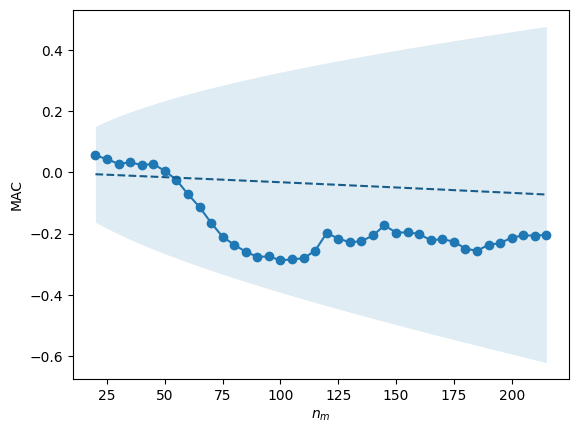

In [16]:
ax = plot_nm_vs_mac1D(
    mags, times, mc, delta_m, x_variable = times, color = '#1f77b4')

ax = plot_nm_vs_mac1D(
    mags, times, mc, delta_m, x_variable = times, color = '#1f77b4')


<font color=#208de2> We found that in fact, the variation of the b-value is not significant for any scale. </font>

## 4. Generate and bin synthetic earthquakes

<font color=#208de2>     
First we need to define the number of earthquakes, the b-value and the completeness magnitude.
</font>

In [39]:
from seismostats import simulate_magnitudes_binned, estimate_b
import matplotlib.pyplot as plt

In [24]:
n = 200
b_value = 1.5
delta_m = 0.05
mc = 3
dmc = 0.3

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [25]:
mags = simulate_magnitudes_binned(n, b_value, mc, delta_m)

<font color=#208de2> In order to bin the magnitudes, we just need to define the step-size: </font>

In [26]:
b_estimate, error = estimate_b(mags, mc=mc, delta_m=delta_m, return_std=True, b_parameter='b_value')

<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that we choose the bin position to be left in order to align the binned and the original magnitudes. </font>

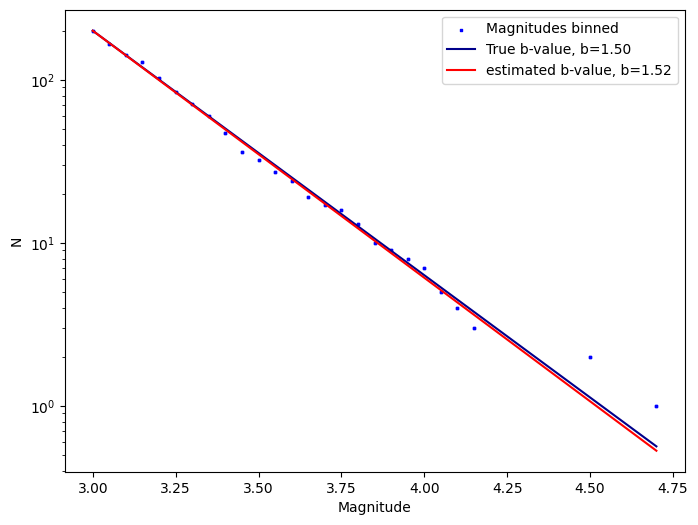

In [27]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(mags, ax=ax, b_value=b_value, mc=mc - delta_m/2, 
             color=['blue', 'darkblue'], legend=['Magnitudes binned', 'True b-value'], size=3)
plot_cum_fmd(mags, ax=ax, b_value=b_estimate, mc=mc - delta_m/2, 
             color=['blue', 'red'], legend=['_', 'estimated b-value'], size=3)

plt.show()